### Candidate details:
Name : Natraj Vikram S

email id : vikram.iisccamp@gmail.com

### Overview:

- Problem statement defined : In most online QA forums , some questions that the user is intending to ask may have already been answered before and might be semantically similar to another question but with a slightly different word order and sentence structure.  
- So the task here is to find out those pairs of questions which are semantically similar using NLP and Machine Learning
- Possible use case scenario for this task : Prompt the user to check those other existing similar questions  before posting anything new. 

For this the following approach has been used and it is been divided into 3 parts:

1) Train a word2vec model for generating word vectors using our own custom data corpus.

2) Find out and detect those questions which are implicitly or explicitly asking another user about something specific. Ignore non interrogative type questions and garbage question types.

3) Use the trained word2vec model to find out similar questions (finding semantic duplicates) using cosine similarity metric. 

Input : question

Output : List of other  questions which are similar and which have been answered previously


Note - For generating word2vec embeddings , I have used the entire corpus from dialogueText.csv but for the similarity detection task I have only considered some datapoints.

### Results 
The final results of the similarity detection task is present in *similar_questions.xlsx*

In [1]:
## Import all the necessary libraries and modules

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib notebook
import numpy as np
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import re  # For preprocessing
import pandas as pd  # For data handling
from time import time  # To time our operations
from collections import defaultdict  # For word frequency

from gensim.models import Word2Vec
import logging  # Setting up the loggings to monitor gensim
logging.basicConfig(format="%(levelname)s - %(asctime)s: %(message)s", datefmt= '%H:%M:%S', level=logging.INFO)
from sklearn.manifold import TSNE
from numpy import dot
from numpy.linalg import norm
import nltk
from tqdm import tqdm
from nltk.corpus import stopwords 
import tensorflow as tf
tf.compat.v1.disable_eager_execution()
import tensorflow_hub as hub
from tensorflow.python.keras import layers
from tensorflow.python.keras.models import Model
from tensorflow.python.keras import backend as K
from tensorflow.compat.v1 import global_variables_initializer,tables_initializer

# Dataset Description 

The dataset that has been used for this assignment is from Kaggle( https://www.kaggle.com/rtatman/ubuntu-dialogue-corpus) 

It is the new Ubuntu Dialogue Corpus which consists of almost one million two-person conversations extracted from the Ubuntu chat logs, used to receive technical support for various Ubuntu-related problems. The conversations have an average of 8 turns each, with a minimum of 3 turns. 

It has the following columns:
- folder: The folder that a dialogue comes from. Each file contains dialogues from one folder .
- dialogueID: An ID number for a specific dialogue. Dialogue ID’s are reused across folders.
- date: A timestamp of the time this line of dialogue was sent.
- from: The user who sent that line of dialogue.
- to: The user to whom they were replying. On the first turn of a dialogue, this field is blank.
- text: The text of that turn of dialogue, separated by double quotes (“). Line breaks (\n) have been removed.

In [2]:
df=pd.read_csv('dialogueText.csv')

In [3]:
df

,folder,dialogueID,date,from,to,text
0,3,126125.tsv,2008-04-23T14:55:00.000Z,bad_image,NaN,"Hello folks, please help me a bit with the fol..."
1,3,126125.tsv,2008-04-23T14:56:00.000Z,bad_image,NaN,Did I choose a bad channel? I ask because you ...
2,3,126125.tsv,2008-04-23T14:57:00.000Z,lordleemo,bad_image,the second sentence is better english and we...
3,3,64545.tsv,2009-08-01T06:22:00.000Z,mechtech,NaN,Sock Puppe?t
4,3,64545.tsv,2009-08-01T06:22:00.000Z,mechtech,NaN,WTF?
...,...,...,...,...,...,...
1038319,3,51506.tsv,2012-01-31T10:56:00.000Z,DJ,NaN,anyone on?
1038320,3,51506.tsv,2012-01-31T10:56:00.000Z,aeon-ltd,DJ,yes
1038321,3,99669.tsv,2008-11-16T20:11:00.000Z,KR-data,NaN,can I get a pastebin of someones menu.lst with...
1038322,3,99669.tsv,2008-11-16T20:12:00.000Z,outbackwifi,KR-data,http://pastebin.com/fe921690


In [4]:
df.shape

(1038324, 6)

In [5]:
df = df.drop_duplicates(['text'])

In [6]:
df = df[df['text'].notna()]

In [7]:
df.shape

(863907, 6)

# 1) Train word2vec model using custom corpus
## Data Preprocessing


Genism word2Vec requires that a format of list of list for training where every document is contained in a list and every list contains list of tokens of that document. At first, we need to generate a format of list of list for training the make model word embedding.

Before that we are going to follow these text preprocessing steps :
1. Create a new column for the preprocessed text 
2. Apply text preprocessing steps on text column : removing stopwords,removing url and email id, decontracting phrases (won't --> will not) , removing digits , removing special characters
3. Store this preprocessed text in the new column that we created earlier

In [8]:

stpwrds = stopwords.words("english") #load stopwords from nltk library


# https://stackoverflow.com/a/47091490/4084039
def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)
    phrase = re.sub(r"didn\'t", "did not", phrase)
    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    #phrase = re.sub(r'^https?:\/\/.*[\r\n]*', '', phrase, flags=re.MULTILINE)
    
    return phrase





def preprocess_txt(raw_text):
    
    preprocessed_text = []
    # tqdm is for printing the status bar
    for sentence in tqdm(raw_text):
        em_id = re.findall('\S*@\S*\s?', sentence) #find all email id
        sentence = ' '.join(e for e in sentence.split() if e not in em_id)  #remove email id tags
        
        sent = decontracted(sentence)
        
        
        
        
        sent = re.sub(r'\w+:\/{2}[\d\w-]+(\.[\d\w-]+)*(?:(?:\/[^\s/]*))*', '', sent) #remove https url
        
        
        
        
        
        sent = re.sub(r'\<[^)]*\>', '', sent)
        sent = re.sub(r'\[[^)]*\]', '', sent)
        
        



        sent = sent.replace('\\r', ' ')
        sent = sent.replace('\\"', ' ')
        sent = sent.replace('\\n', ' ')
        
        sent = re.sub('[^A-Za-z0-9]+', ' ', sent)   #remove all special characters using regex
        
        sent = re.sub("\d+", " ", sent)  #remove digits
        
        
        
        sent = ' '.join(e for e in sent.split() if e not in stpwrds) #remove stopwords
        
        preprocessed_text.append(sent.strip())
        
    return preprocessed_text

In [9]:
df['preprocessed_text'] = [i.lower() for i in df['text'].tolist()]

In [10]:
df['preprocessed_text'] = preprocess_txt(df['preprocessed_text'].tolist())

100%|██████████| 863907/863907 [00:33<00:00, 25900.48it/s]


In [11]:
tok_corp = [nltk.word_tokenize(sent) for sent in tqdm(df['preprocessed_text'])]

100%|██████████| 863907/863907 [00:56<00:00, 15194.55it/s]


In [13]:
tok_corp[0:5]
#sentence tokens after text preprocessing
#train data for word2vec (only the first 5 points)

[['hello',
  'folks',
  'please',
  'help',
  'bit',
  'following',
  'sentence',
  'order',
  'personal',
  'photos',
  'videos',
  'think',
  'allowed',
  'version',
  'order',
  'personal',
  'videos',
  'photos',
  'sure'],
 ['choose',
  'bad',
  'channel',
  'ask',
  'seem',
  'dumb',
  'like',
  'windows',
  'user'],
 ['second', 'sentence', 'better', 'english', 'dumb'],
 ['sock', 'puppe'],
 ['wtf']]

## Model hyperparameters: 
Let's try to understand the hyperparameter of this model.
1. size: The number of dimensions of the embeddings and the default is 100.
2. window: The maximum distance between a target word and words around the target word. The default window is 5.
3. min_count: The minimum count of words to consider when training the model; words with occurrence less than this count will be ignored. The default for min_count is 5.
4. workers: The number of partitions during training and the default workers is 3. 
5. sg: The training algorithm, either CBOW(0) or skip gram (1). The default training alogrithm is CBOW. 

In [14]:
## Train the genisim word2vec model with our own custom corpus
model = Word2Vec(tok_corp, min_count=1,size= 300,workers=3, window = 3)


INFO - 17:44:54: collecting all words and their counts
INFO - 17:44:54: PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO - 17:44:54: PROGRESS: at sentence #10000, processed 59716 words, keeping 8013 word types
INFO - 17:44:54: PROGRESS: at sentence #20000, processed 119931 words, keeping 11867 word types
INFO - 17:44:54: PROGRESS: at sentence #30000, processed 178730 words, keeping 15012 word types
INFO - 17:44:54: PROGRESS: at sentence #40000, processed 239685 words, keeping 17841 word types
INFO - 17:44:54: PROGRESS: at sentence #50000, processed 300180 words, keeping 20231 word types
INFO - 17:44:54: PROGRESS: at sentence #60000, processed 361505 words, keeping 22561 word types
INFO - 17:44:54: PROGRESS: at sentence #70000, processed 422540 words, keeping 24713 word types
INFO - 17:44:54: PROGRESS: at sentence #80000, processed 483508 words, keeping 26715 word types
INFO - 17:44:54: PROGRESS: at sentence #90000, processed 544445 words, keeping 28540 word types


INFO - 17:44:55: PROGRESS: at sentence #840000, processed 5238038 words, keeping 111892 word types
INFO - 17:44:55: PROGRESS: at sentence #850000, processed 5301817 words, keeping 112646 word types
INFO - 17:44:55: PROGRESS: at sentence #860000, processed 5365006 words, keeping 113454 word types
INFO - 17:44:55: collected 113758 word types from a corpus of 5389604 raw words and 863907 sentences
INFO - 17:44:55: Loading a fresh vocabulary
INFO - 17:44:55: effective_min_count=1 retains 113758 unique words (100% of original 113758, drops 0)
INFO - 17:44:55: effective_min_count=1 leaves 5389604 word corpus (100% of original 5389604, drops 0)
INFO - 17:44:55: deleting the raw counts dictionary of 113758 items
INFO - 17:44:55: sample=0.001 downsamples 47 most-common words
INFO - 17:44:55: downsampling leaves estimated 4984419 word corpus (92.5% of prior 5389604)
INFO - 17:44:55: estimated required memory for 113758 words and 300 dimensions: 329898200 bytes
INFO - 17:44:55: resetting layer we

### Generating sentence embeddings and dealing with out of vocabulary words:

- Word2vec can only give the word vectors/embeddings and not sentence embeddings directly. In order to generate sentence embeddings we average the word vectors present in the sentence and get the sentence embeddings. (average word2vec) 
- for words which are outside the vocabulary of what word2vec was trained with , the sentence embedding for that  is just a 300 dimensional numpy array with zeros inside.

In [15]:
def sent_embedding_w2v(sentence): #input sentence, output - sentence embedding (average word2vec)

    sentence = preprocess_txt([sentence.lower()])[0]
    words = sentence.split()
    emb = []
    for word in words:
        try:
            wrd_emb = model[word]
#             print(word)
            
        except:
#             print('oov',word)    
            wrd_emb = np.zeros(300)

        emb.append(wrd_emb)
    emb = np.array(emb)
    sent_vect = np.mean(emb,axis=0)
    return sent_vect

# Compare Similarities of two words using the trained model

Now we could even use Word2vec to compute similarity between two make model in the vocabulary by invoking the model.similarity() and passing in the relvevant words.  This will give us the cosine similarity between two words. 

In [16]:
model.similarity('pc', 'computer')

0.832106

In [17]:
model.similarity('debian', 'fedora')

0.6975051

In [18]:
model.similarity('system', 'computer')

0.617589

In [19]:
model.most_similar('pc')[:5]

INFO - 04:58:28: precomputing L2-norms of word weight vectors


[('computer', 0.8321059942245483),
 ('machine', 0.7915535569190979),
 ('comp', 0.7887583374977112),
 ('laptop', 0.7597492337226868),
 ('computers', 0.6464474201202393)]

In [20]:
model.most_similar('computer')[:5]

[('pc', 0.8321060538291931),
 ('machine', 0.7959321737289429),
 ('comp', 0.7737423777580261),
 ('laptop', 0.6960322856903076),
 ('computers', 0.6542994379997253)]

In [21]:
model.most_similar('fedora')[:10]

[('suse', 0.8260831236839294),
 ('slackware', 0.8255550265312195),
 ('mandrake', 0.7763886451721191),
 ('opensuse', 0.7759972214698792),
 ('redhat', 0.7739011645317078),
 ('gentoo', 0.7640926837921143),
 ('mandriva', 0.7474093437194824),
 ('debian', 0.6975050568580627),
 ('freebsd', 0.6926039457321167),
 ('centos', 0.6809220314025879)]

In [22]:
model.most_similar('system')[:10]

[('systems', 0.7352992296218872),
 ('computer', 0.617588996887207),
 ('machine', 0.5671004056930542),
 ('sys', 0.5605801343917847),
 ('isystem', 0.5564244389533997),
 ('differetn', 0.5497311353683472),
 ('sessins', 0.5147553086280823),
 ('sytem', 0.48830077052116394),
 ('pc', 0.477489173412323),
 ('systmes', 0.46782374382019043)]

In [23]:
model.most_similar('debian')[:10]

[('redhat', 0.7143198847770691),
 ('gentoo', 0.7035437822341919),
 ('fedora', 0.6975050568580627),
 ('sid', 0.6922509074211121),
 ('slackware', 0.6664004921913147),
 ('centos', 0.647232711315155),
 ('mandrake', 0.6318177580833435),
 ('sarge', 0.6273603439331055),
 ('suse', 0.6144251227378845),
 ('unstable', 0.5926075577735901)]

In [24]:
model.most_similar('linux')[:10]

[('nix', 0.6269590258598328),
 ('ubuntu', 0.587287425994873),
 ('os', 0.5474276542663574),
 ('unix', 0.5104696750640869),
 ('ms', 0.5037236213684082),
 ('microsoft', 0.5017520189285278),
 ('osx', 0.5010915398597717),
 ('bsd', 0.4926564693450928),
 ('xp', 0.48380541801452637),
 ('sayabon', 0.48004648089408875)]

In [15]:
model.save("word2vec.model") #save the trained model

INFO - 17:45:45: saving Word2Vec object under word2vec.model, separately None
INFO - 17:45:45: storing np array 'vectors' to word2vec.model.wv.vectors.npy
INFO - 17:45:45: not storing attribute vectors_norm
INFO - 17:45:45: storing np array 'syn1neg' to word2vec.model.trainables.syn1neg.npy
INFO - 17:45:45: not storing attribute cum_table
INFO - 17:45:45: saved word2vec.model


In [16]:
# from gensim.models import Word2Vec
# model = Word2Vec.load("word2vec.model")

# T-SNE Plot

It’s hard to visualize the word embedding directly, for they usually has more than 3 dimensions. T-SNE is an useful tool to visualize high-dimensional data by reducing dimensional space while keeping relative pairwise distance between points. It can be said that t-SNE looking for a new data representation where the neighborhood relations are preserved.  The following code showed how to plot the word embedding with T-SNE plot. 

In [26]:
def display_closestwords_tsnescatterplot(model, word, size):
    
    arr = np.empty((0,size), dtype='f')
    word_labels = [word]

    close_words = model.similar_by_word(word)
    print(close_words)
    arr = np.append(arr, np.array([model[word]]), axis=0)
    for wrd_score in close_words:
        wrd_vector = model[wrd_score[0]]
        word_labels.append(wrd_score[0])
        arr = np.append(arr, np.array([wrd_vector]), axis=0)
        
    tsne = TSNE(n_components=2, random_state=0)
    np.set_printoptions(suppress=True)
    Y = tsne.fit_transform(arr)

    x_coords = Y[:, 0]
    y_coords = Y[:, 1]
    plt.scatter(x_coords, y_coords)

    for label, x, y in zip(word_labels, x_coords, y_coords):
        plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points')
    plt.xlim(x_coords.min()+0.00005, x_coords.max()+0.00005)
    plt.ylim(y_coords.min()+0.00005, y_coords.max()+0.00005)
    plt.show()


[('ubunto', 0.65968918800354), ('unbuntu', 0.5959628820419312), ('linux', 0.5828112959861755), ('os', 0.5795283317565918), ('xubuntu', 0.5689648985862732), ('xp', 0.544086217880249), ('currently', 0.5356205701828003), ('fully', 0.5217772722244263), ('ubunut', 0.5184593796730042), ('however', 0.5075225830078125)]


<IPython.core.display.Javascript object>


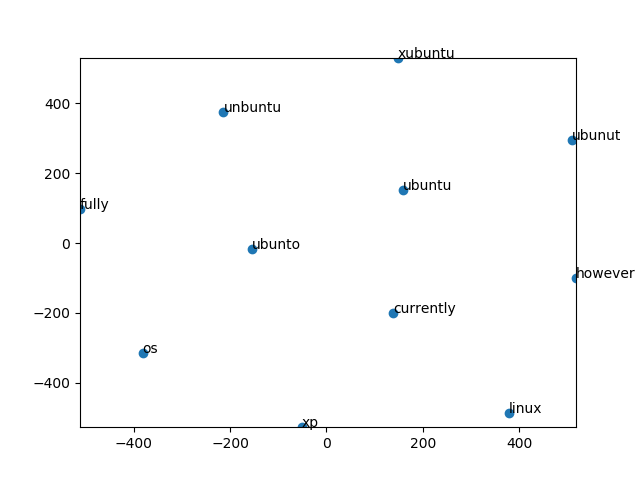

In [28]:
display_closestwords_tsnescatterplot(model, 'ubuntu', 300)

[('gentoo', 0.7062795758247375), ('fedora', 0.6906126141548157), ('redhat', 0.6833741068840027), ('sid', 0.6725113391876221), ('sarge', 0.6437418460845947), ('centos', 0.6395323872566223), ('slackware', 0.6395044922828674), ('suse', 0.6003413200378418), ('unstable', 0.5797812938690186), ('arch', 0.5783550143241882)]


<IPython.core.display.Javascript object>


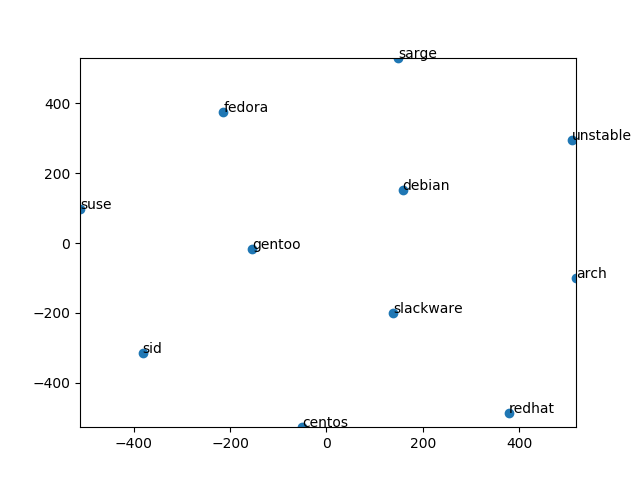

In [29]:
display_closestwords_tsnescatterplot(model, 'debian', 300)

[('computer', 0.8261830806732178), ('machine', 0.8029240965843201), ('comp', 0.784569501876831), ('laptop', 0.7606219053268433), ('computers', 0.6938121914863586), ('pcs', 0.6653099060058594), ('machines', 0.6564359664916992), ('box', 0.6310288310050964), ('xp', 0.6069440841674805), ('notebook', 0.6031737327575684)]


<IPython.core.display.Javascript object>


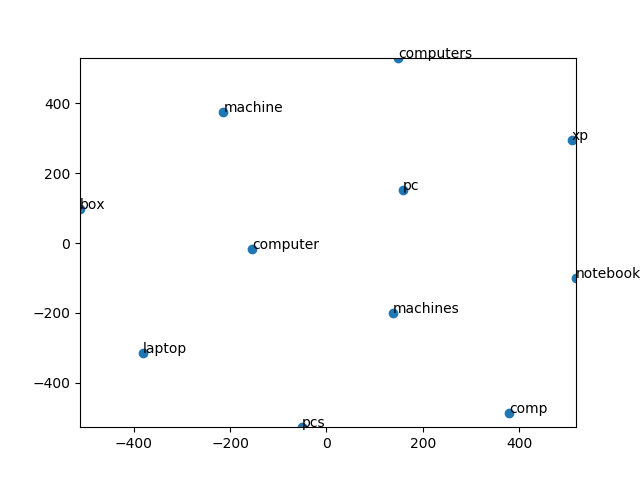

In [30]:
display_closestwords_tsnescatterplot(model, 'pc', 300)

### Observations:
- The trained word2vec model is able fetch pretty good embeddings and find similar words based on cosine similarity measure.

## 2) Interrogative question detection : 
- Some user questions may belong to garbage category and those questions may not be useful because the user is not trying to ask anything specific there. 
- For this I have fine tuned the last layer of existing Google's Universal Sentence Encoder model for classifying interrogative from non interrogative question types. 
For training this model, I had used data from open source GitHub repositories. (https://github.com/lettergram/sentence-classification) (https://github.com/anshu-singla/Is_This_Interrogative-)
- The fine tuned model works pretty well in detecting whether a question is interrogative or not.
- After training ,I saved the last layers weights (model.h5)
- Input : question , Output - 1 if it is of interrogative type and 0 if it is not interrogative

In [1]:
####download model before running
download_url = 'https://tfhub.dev/google/universal-sentence-encoder-large/3'
print('download model from',download_url)

download model from https://tfhub.dev/google/universal-sentence-encoder-large/3


In [4]:
modl_file = 'universal-sentence-encoder-large_3'
# Import the Universal Sentence Encoder's TF Hub module
embed = hub.Module(modl_file)

INFO - 03:58:47: resolver HttpCompressedFileResolver does not support the provided handle.
INFO - 03:58:47: resolver GcsCompressedFileResolver does not support the provided handle.
INFO - 03:58:47: resolver HttpUncompressedFileResolver does not support the provided handle.


In [5]:
def UniversalEmbedding(x):
    return embed(tf.squeeze(tf.cast(x, tf.string),axis=1), signature="default", as_dict=True)["default"]



def q_predict(new_text):      #array of input strings
    embed_size = embed.get_output_info_dict()['default'].get_shape()[1] #512 embedding size
    category_counts = 2
    input_text = layers.Input(shape=(1,), dtype=tf.string)
    embedding = layers.Lambda(UniversalEmbedding,output_shape=(embed_size,))(input_text)
    dense = layers.Dense(256, activation='relu')(embedding)
    pred = layers.Dense(category_counts, activation='softmax')(dense)
    model = Model(inputs=[input_text], outputs=pred)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    #model.summary()
    print('-'*50)

    new_text = np.array(new_text, dtype=object)[:, np.newaxis]
    with tf.compat.v1.Session() as session:
        K.set_session(session)
        session.run(global_variables_initializer())
        session.run(tables_initializer())
        model.load_weights('./model.h5')      #load model weights (fine tuned model)
        predicts = model.predict(new_text, batch_size=32)
    predicts = np.argmax(predicts,axis=1)
    return predicts

In [6]:
df=pd.read_csv('dialogueText.csv')
df = df[df['text'].notna()]
df = df.drop_duplicates(['text'],keep='last')
df['text'] = df['text'].astype(str) 

In [7]:
df = df[df['to'].isnull()]

In [8]:
arr_q =df['text'].tolist()

In [9]:
len(arr_q)

386622

In [10]:
### Note :- reduced data points

In [12]:
df = df[0:800]

In [11]:
print('-'*50)
print('Find if a given question is of interrogative type')
predictions = q_predict(arr_q[0:800]) #1 or 0

--------------------------------------------------
Find if a given question is of interrogative type


INFO - 04:06:30: Saver not created because there are no variables in the graph to restore


--------------------------------------------------


WARNING - 04:06:33: From /home/vikram/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/engine/training_v1.py:2070: Model.state_updates (from tensorflow.python.keras.engine.training) is deprecated and will be removed in a future version.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


In [13]:
df['interr_question'] = predictions

In [14]:
df.to_excel('predictions.xlsx',index=False)

## 3) Use the trained word2vec model to find out similar questions (finding semantic duplicates) using cosine similarity metric.

In [15]:
from sklearn.metrics.pairwise import cosine_similarity

In [16]:
df = pd.read_excel('predictions.xlsx') #load the predictions data found in step2
df['text'] = df['text'].astype(str) 

In [17]:
df.head()

,folder,dialogueID,date,from,to,text,interr_question
0,3,64545.tsv,2009-08-01T06:22:00.000Z,mechtech,NaN,Sock Puppe?t,0
1,3,122495.tsv,2008-03-12T03:50:00.000Z,Sinnerman,NaN,is there any reason why my 'network manager' i...,1
2,3,208201.tsv,2008-08-21T12:49:00.000Z,BigBuddha,NaN,how do fix vlc in the terminal?,1
3,3,176813.tsv,2007-05-17T12:01:00.000Z,svizzero,NaN,I installed the 64bit version of ubuntu and I ...,1
4,3,176813.tsv,2007-05-17T12:02:00.000Z,svizzero,NaN,Anyone knows why after I installed the 64bit v...,1


In [18]:
df = df[df['interr_question']==1] #filter only the interrogative type questions

In [19]:
#find cosine similarity between two vectors
def cosine_sim(a, b):

    a = a.reshape(1, -1)

    b = b.reshape(1, -1)

    result = cosine_similarity(a, b)

    return result[0][0]

In [20]:
#inp - input sentence, nd - dataframe , emb_qq - all the question embeddings
#output - top similar questions based on word embeddings and cosine similarity score
def get_sim_quesn(inp, nd, emb_qq):   
    
    inp_embedding = np.array(sent_embedding_w2v(inp)) #find sentence embedding of input sentence using word2vec
    
    scores = []
    for i in range(len(nd)):
        
        scores.append(cosine_sim(inp_embedding, emb_qq[i]))  #find cosine similarity of one question with every other question in the list

    scores = np.array(scores) #append the cosine scores

    top3_indices = scores.argsort()[:][::-1] #high cosine score => most similar

    top3_sim_scores = []
    for i in top3_indices:
        top3_sim_scores.append(scores[i])  #append those scores
    top3_questions = []
    top3_answers = []
    from_user = []
    
    for i in top3_indices:
        top3_questions.append(nd['text'].iloc[i]) #similar questions for inp
        from_user.append(nd['from'].iloc[i]) #similar question from user
        
        

        

    return inp,top3_questions[1],from_user[1],top3_sim_scores[1]

In [23]:
from gensim.models import Word2Vec
model = Word2Vec.load("word2vec.model")

INFO - 04:15:54: loading Word2Vec object from word2vec.model
INFO - 04:15:54: loading wv recursively from word2vec.model.wv.* with mmap=None
INFO - 04:15:54: loading vectors from word2vec.model.wv.vectors.npy with mmap=None
INFO - 04:15:54: setting ignored attribute vectors_norm to None
INFO - 04:15:54: loading vocabulary recursively from word2vec.model.vocabulary.* with mmap=None
INFO - 04:15:54: loading trainables recursively from word2vec.model.trainables.* with mmap=None
INFO - 04:15:54: loading syn1neg from word2vec.model.trainables.syn1neg.npy with mmap=None
INFO - 04:15:54: setting ignored attribute cum_table to None
INFO - 04:15:54: loaded word2vec.model


In [25]:
questions = df['text'].tolist()

In [26]:
qe = [sent_embedding_w2v(i) for i in tqdm(questions)]

100%|██████████| 1/1 [00:00<00:00, 1098.85it/s]

100%|██████████| 1/1 [00:00<00:00, 10010.27it/s]

100%|██████████| 1/1 [00:00<00:00, 7332.70it/s]

100%|██████████| 1/1 [00:00<00:00, 6364.65it/s]

100%|██████████| 1/1 [00:00<00:00, 7958.83it/s]

100%|██████████| 1/1 [00:00<00:00, 7543.71it/s]

100%|██████████| 1/1 [00:00<00:00, 3097.71it/s]

100%|██████████| 1/1 [00:00<00:00, 4809.98it/s]

100%|██████████| 1/1 [00:00<00:00, 9425.40it/s]

100%|██████████| 1/1 [00:00<00:00, 4951.95it/s]

100%|██████████| 1/1 [00:00<00:00, 7423.55it/s]

100%|██████████| 1/1 [00:00<00:00, 6326.25it/s]

100%|██████████| 1/1 [00:00<00:00, 5356.71it/s]

100%|██████████| 1/1 [00:00<00:00, 4215.38it/s]

100%|██████████| 1/1 [00:00<00:00, 7145.32it/s]

100%|██████████| 1/1 [00:00<00:00, 5518.82it/s]

100%|██████████| 1/1 [00:00<00:00, 4624.37it/s]

100%|██████████| 1/1 [00:00<00:00, 7281.78it/s]

100%|██████████| 1/1 [00:00<00:00, 9078.58it/s]

100%|██████████| 1/1 [00:00<00:00, 7557.30it/s]

100%|██████████| 1/

100%|██████████| 1/1 [00:00<00:00, 6017.65it/s]

100%|██████████| 1/1 [00:00<00:00, 8867.45it/s]

100%|██████████| 1/1 [00:00<00:00, 6159.04it/s]

100%|██████████| 1/1 [00:00<00:00, 10058.28it/s]

100%|██████████| 1/1 [00:00<00:00, 9939.11it/s]

100%|██████████| 1/1 [00:00<00:00, 7825.19it/s]

100%|██████████| 1/1 [00:00<00:00, 8648.05it/s]

100%|██████████| 1/1 [00:00<00:00, 9362.29it/s]

100%|██████████| 1/1 [00:00<00:00, 7752.87it/s]

100%|██████████| 1/1 [00:00<00:00, 7256.58it/s]

100%|██████████| 1/1 [00:00<00:00, 8272.79it/s]

100%|██████████| 1/1 [00:00<00:00, 8456.26it/s]

100%|██████████| 1/1 [00:00<00:00, 4888.47it/s]

100%|██████████| 1/1 [00:00<00:00, 2186.81it/s]

100%|██████████| 1/1 [00:00<00:00, 8160.12it/s]

100%|██████████| 1/1 [00:00<00:00, 9915.61it/s]

100%|██████████| 1/1 [00:00<00:00, 10618.49it/s]

100%|██████████| 1/1 [00:00<00:00, 7973.96it/s]

100%|██████████| 1/1 [00:00<00:00, 7307.15it/s]

100%|██████████| 1/1 [00:00<00:00, 7989.15it/s]

100%|██████████| 1

In [27]:
q = []
sim_q = []
cos = []
fu = []
u = []
for i in tqdm(range(len(questions))):
    op = get_sim_quesn(questions[i],df,qe)
    u.append(df['from'].iloc[i])
    q.append(op[0])
    sim_q.append(op[1])
    fu.append(op[2])
    cos.append(op[3])
    

100%|██████████| 1/1 [00:00<00:00, 2941.31it/s]

100%|██████████| 1/1 [00:00<00:00, 7108.99it/s]

100%|██████████| 1/1 [00:00<00:00, 9664.29it/s]

100%|██████████| 1/1 [00:00<00:00, 8192.00it/s]

100%|██████████| 1/1 [00:00<00:00, 8388.61it/s]

100%|██████████| 1/1 [00:00<00:00, 7557.30it/s]

100%|██████████| 1/1 [00:00<00:00, 10034.22it/s]

100%|██████████| 1/1 [00:00<00:00, 8756.38it/s]

100%|██████████| 1/1 [00:00<00:00, 7653.84it/s]

100%|██████████| 1/1 [00:00<00:00, 10205.12it/s]

100%|██████████| 1/1 [00:00<00:00, 6786.90it/s]

100%|██████████| 1/1 [00:00<00:00, 6000.43it/s]

100%|██████████| 1/1 [00:00<00:00, 7145.32it/s]

100%|██████████| 1/1 [00:00<00:00, 10280.16it/s]

100%|██████████| 1/1 [00:00<00:00, 8289.14it/s]

100%|██████████| 1/1 [00:00<00:00, 10699.76it/s]

100%|██████████| 1/1 [00:00<00:00, 11650.84it/s]

100%|██████████| 1/1 [00:00<00:00, 10058.28it/s]

100%|██████████| 1/1 [00:00<00:00, 12300.01it/s]

100%|██████████| 1/1 [00:00<00:00, 8192.00it/s]

100%|████████

100%|██████████| 1/1 [00:00<00:00, 6345.39it/s]

100%|██████████| 1/1 [00:00<00:00, 8289.14it/s]

100%|██████████| 1/1 [00:00<00:00, 7319.90it/s]

100%|██████████| 1/1 [00:00<00:00, 3945.72it/s]

100%|██████████| 1/1 [00:00<00:00, 7557.30it/s]

100%|██████████| 1/1 [00:00<00:00, 8144.28it/s]

100%|██████████| 1/1 [00:00<00:00, 11096.04it/s]

100%|██████████| 1/1 [00:00<00:00, 7516.67it/s]

100%|██████████| 1/1 [00:00<00:00, 2225.09it/s]

100%|██████████| 1/1 [00:00<00:00, 10131.17it/s]

100%|██████████| 1/1 [00:00<00:00, 6842.26it/s]

100%|██████████| 1/1 [00:00<00:00, 9664.29it/s]

100%|██████████| 1/1 [00:00<00:00, 7543.71it/s]

100%|██████████| 1/1 [00:00<00:00, 10180.35it/s]

100%|██████████| 1/1 [00:00<00:00, 6512.89it/s]

100%|██████████| 1/1 [00:00<00:00, 7256.58it/s]

100%|██████████| 1/1 [00:00<00:00, 4644.85it/s]

100%|██████████| 1/1 [00:00<00:00, 6668.21it/s]

100%|██████████| 1/1 [00:00<00:00, 9709.04it/s]

100%|██████████| 1/1 [00:00<00:00, 9425.40it/s]

100%|██████████| 

100%|██████████| 1/1 [00:00<00:00, 6413.31it/s]

100%|██████████| 1/1 [00:00<00:00, 8542.37it/s]

100%|██████████| 1/1 [00:00<00:00, 5178.15it/s]

100%|██████████| 1/1 [00:00<00:00, 7371.36it/s]

100%|██████████| 1/1 [00:00<00:00, 10459.61it/s]

100%|██████████| 1/1 [00:00<00:00, 11650.84it/s]

100%|██████████| 1/1 [00:00<00:00, 10837.99it/s]

100%|██████████| 1/1 [00:00<00:00, 8648.05it/s]

100%|██████████| 1/1 [00:00<00:00, 1702.23it/s]

100%|██████████| 1/1 [00:00<00:00, 10330.80it/s]

100%|██████████| 1/1 [00:00<00:00, 9686.61it/s]

100%|██████████| 1/1 [00:00<00:00, 10645.44it/s]

100%|██████████| 1/1 [00:00<00:00, 8981.38it/s]

100%|██████████| 1/1 [00:00<00:00, 5769.33it/s]

100%|██████████| 1/1 [00:00<00:00, 9279.43it/s]

100%|██████████| 1/1 [00:00<00:00, 9664.29it/s]

100%|██████████| 476/476 [00:43<00:00, 10.95it/s]


In [28]:
fdf = pd.DataFrame({'from':u,'question':q,'similar_question':sim_q,'similar_question_from':fu,'cosine_score':cos})

In [29]:
df1 = pd.DataFrame(np.sort(fdf[['question','similar_question']], axis=1))

In [30]:
fdf = fdf[~df1.duplicated()]

In [31]:
fdf = fdf[fdf['cosine_score']>=0.8] ## apply cosine threshold of 0.8 or above to fetch similar pairs

In [2]:
fdf = pd.read_excel('similar_questions.xlsx')

In [4]:
fdf = fdf.drop_duplicates(['from','similar_question_from'])

In [5]:
fdf.to_excel('similar_questions.xlsx',index=False)

In [6]:
fdf

,from,question,similar_question,similar_question_from,cosine_score
0,Sinnerman,is there any reason why my 'network manager' i...,what is the name of the task that controls the...,sfire,0.849693
1,biabia,"ok, anyone know how I set bios password in ubuntu",i installed my ubuntu again saving /home and s...,purma,0.807493
2,dft,anyone else run into issues with cd/dvd burner...,Has anyone here had any problems installing ka...,RB2_,0.850776
3,hooligan,Where does synoptic install the programs to? L...,"hi, is there a way to install Ubuntu from the ...",etrask,0.820996
4,Faustus2,is there a way to tell ubuntu not to show icon...,is there a config to tell ubuntu to use usb2 p...,z993126,0.808217
...,...,...,...,...,...
160,redwyrm,"When I run apt-get, it crashes halfway through...",guys is it possible to do a clean install of m...,XB23,0.819565
161,Enissay,"I've just installed Ubuntu, and i can't access...","Okay I'm looking for a hand, I've spent tons o...",niftylettuce,0.860785
162,Error404NotFound,When upgrading from commandline i see '13 pack...,hello all -- quick question: I came across som...,Fotinakis,0.831335
163,md22,for someone interested in learning programming...,gahhhh its frickin linux people why cant we he...,dRounse,0.807458


### Observations and Results:
- The final results of the similarity detection task is present in similar_questions.xlsx
- After manual analysis of the results, it was found that some questions are similar and have already been asked in the past. Such queries need not be in the forum. Therefore,this maybe used for prompting users before they post their queries online.
- This validation can also be useful for only maintaining unique questions or records in the forum instead of having unnecessary semantic duplicates.
- The model's performance and the results are far from perfect. But however it can be improved by using more data or tweaking some parameters before training. 